<a href="https://colab.research.google.com/github/shreyadas-maple/BIL_Project_work/blob/main/Build_XGBoost_Tau_SMOTE_vs_NO_SMOTE_(Classification)_F_12_No_data_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Optuna for hyperparameter optimization of the models that we might want to train

%pip install optuna

In [ ]:

import os
import numpy as np
import pandas as pd
from typing import List, Optional

from google.auth import default

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import optuna
import shap
import matplotlib.pyplot as plt

# Optional: nicer printing
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)



# Task
Modify the code to train and tune two XGBoost classifiers using 10-fold cross-validation: one on the original data and one on SMOTE-oversampled data. Perform a statistical test to compare their performance. Do not use a train-test split.

## Load and prepare data

### Subtask:
Load the dataset and select features as done previously. Scale the features.


**Reasoning**:
Load the dataset and select features, create the target variable, and scale the features as per the instructions.



In [ ]:
# 1) Read-in the csv for the dataset
df = pd.read_csv("./ADNI_PET_TAU_EPVS_DTI_ALPS_T1_aparc_aseg_ravens_contrast_EXTRA_TIV_Norm_FW.csv")

# 2) Read the CSV file "F_12.csv" into a pandas DataFrame named features_df.
features_df = pd.read_csv("./F_12.csv", header=None)

# 3) Extract the column names from the features_df DataFrame and store them in a list called feature_names.
feature_names = features_df.iloc[0].tolist()

# 4) Create a new column named 'TAU_POS' in the df DataFrame.
df['TAU_POS'] = (df['META_TEMPORAL_SUVR_TAU'] >= 1.37).astype(int)

# 5) Create a new DataFrame named df_selected_features by selecting the columns specified in feature_names from the df DataFrame.
df_selected_features = df[feature_names]

# 6) Separate the features (X) and the target variable (y).
X = df_selected_features.drop(columns=['META_TEMPORAL_SUVR_TAU']) # Drop the original, not the encoded column
y = df['TAU_POS']

# 7) Initialize a StandardScaler object.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 8) Fit the scaler to the feature data (X) and transform it. Store the scaled features back into the X DataFrame, preserving the original column names.
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# 9) Display the first few rows of the scaled X DataFrame and the y Series to verify the data preparation.
display(X.head())
display(y.head())

,AGE_Actual,PTGENDER,lh_bankssts_volume,lh_caudalmiddlefrontal_volume,lh_entorhinal_volume,lh_frontalpole_volume,lh_fusiform_volume,lh_inferiorparietal_volume,lh_inferiortemporal_volume,lh_insula_volume,lh_isthmuscingulate_volume,lh_lateraloccipital_volume,lh_lateralorbitofrontal_volume,lh_lingual_volume,lh_medialorbitofrontal_volume,lh_middletemporal_volume,lh_parahippocampal_volume,lh_parsopercularis_volume,lh_parsorbitalis_volume,lh_parstriangularis_volume,lh_pericalcarine_volume,lh_postcentral_volume,lh_posteriorcingulate_volume,lh_precuneus_volume,lh_rostralanteriorcingulate_volume,lh_rostralmiddlefrontal_volume,lh_superiorfrontal_volume,lh_superiorparietal_volume,lh_superiortemporal_volume,lh_supramarginal_volume,lh_temporalpole_volume,lh_transversetemporal_volume,rh_bankssts_volume,rh_caudalmiddlefrontal_volume,rh_entorhinal_volume,rh_frontalpole_volume,rh_fusiform_volume,rh_inferiorparietal_volume,rh_inferiortemporal_volume,rh_insula_volume,rh_isthmuscingulate_volume,rh_lateraloccipital_volume,rh_lateralorbitofrontal_volume,rh_lingual_volume,rh_medialorbitofrontal_volume,rh_middletemporal_volume,rh_parahippocampal_volume,rh_parsopercularis_volume,rh_parsorbitalis_volume,rh_parstriangularis_volume,rh_pericalcarine_volume,rh_postcentral_volume,rh_posteriorcingulate_volume,rh_precuneus_volume,rh_rostralanteriorcingulate_volume,rh_rostralmiddlefrontal_volume,rh_superiorfrontal_volume,rh_superiorparietal_volume,rh_superiortemporal_volume,rh_supramarginal_volume,rh_temporalpole_volume,rh_transversetemporal_volume,Right.Amygdala,Left.Amygdala,Right.Hippocampus,Left.Hippocampus,Right.Lateral.Ventricle,Right.Inf.Lat.Vent,Left.Lateral.Ventricle,Left.Inf.Lat.Vent,Right.choroid.plexus,Left.choroid.plexus,X3rd.Ventricle,wm.lh.CSO_ICV,wm.rh.CSO_ICV,EPVS_bg_ICV,alps_L_D5mm,alps_R_D5mm
0,1.793738,1.038393,-0.565971,0.107149,0.461126,0.449215,0.479278,-0.123460,-0.271673,-1.179058,-0.765163,0.611780,0.087038,-0.163405,-1.057978,-0.815071,-0.824959,-0.382101,-0.464227,-0.825011,0.475450,-1.470874,-0.282519,-0.603890,0.382623,0.279572,0.036785,2.194927,-0.719137,-0.270998,0.160233,-0.329723,0.856998,1.013822,0.145597,-0.269676,-0.282432,-0.152776,0.279836,-1.192504,0.723244,0.827081,0.174602,-0.217562,0.479855,-0.261317,-1.457793,-0.431602,0.686626,-1.338252,1.200549,-0.452174,0.072118,0.063585,-2.031644,-0.114557,-0.157809,0.206986,-0.125797,-0.123850,-0.234085,1.544067,-0.512021,-0.679631,-0.837152,-0.551775,0.230837,0.232117,-0.211355,0.531226,1.313191,0.547671,1.564417,1.163618,0.488552,0.139145,-1.556518,-1.048639
1,-1.007036,-0.963026,-0.308843,0.052311,-0.923621,-0.394093,-0.292268,-0.342920,0.636906,-0.558861,-1.052589,0.495173,-1.486006,-1.169344,-0.903487,-0.084523,-1.105275,-1.245786,-1.614876,-1.345120,-0.974696,-0.373821,0.590888,0.533436,-0.476217,-0.496117,-0.767500,0.537830,-0.084763,-0.828367,-0.406438,0.325465,-0.308034,-0.166873,-1.129742,-1.178821,0.141684,1.135877,0.740662,-1.618748,-0.447150,-0.297574,-1.216086,-0.383855,-1.094963,-0.325458,-0.783350,-1.542210,-1.247519,-1.460603,-1.261514,-1.548465,0.297223,-0.428998,0.734074,-0.782123,-0.413771,-0.050555,-0.011260,-0.216533,-0.899918,-1.022896,0.231729,0.382105,0.086659,0.143631,0.887106,-0.029554,0.377338,0.303697,-0.607983,-0.704391,-0.484404,0.561683,0.096364,2.806813,-1.485570,-1.394272
2,0.885583,1.038393,0.265939,0.022163,-1.631952,-1.304188,-1.258338,-1.285999,0.324383,-1.437455,-0.399347,-0.909242,-0.872469,-0.253561,-1.480866,-1.375300,-0.542560,-0.570797,0.581735,-0.553728,0.261733,0.376432,0.094641,-1.024684,-0.711029,-1.141540,-1.480121,-0.377805,-0.312961,0.149903,-1.411496,-1.122573,-0.564608,-0.087441,-0.944072,0.973761,-0.584744,-0.088340,0.737364,-1.531788,0.303600,-1.562687,-0.119072,-0.209787,-0.911034,-0.349211,-1.225261,0.025532,0.082923,-1.460425,0.958909,0.413731,-0.576880,-0.410737,-0.020394,-0.269875,-0.785067,-0.411067,-0.918950,-0.546028,-1.617139,0.514742,-1.924965,-1.822421,-1.933586,-1.771191,1.351984,1.549655,0.600786,1.811493,0.3897

,TAU_POS
0,0
1,0
2,0
3,0
4,0


In [ ]:
# Drop rows with NaN values from X
X = X.dropna()

# Ensure that the indices of X and y still align after dropping rows
# This step is crucial if rows were dropped from X based on index.
# If dropping based on a specific column and not all NaNs are in that column,
# you might need a more sophisticated approach to keep X and y aligned.
# Assuming NaNs are in PTGENDER as checked previously and correspond to rows
# that should also be removed from y.
# Identify the indices to keep in y based on the non-NaN indices in X
y = y[X.index]

# Display the number of rows remaining in X and the class distribution of the updated y
print(f"Number of rows in X after dropping NaNs: {len(X)}")
print("Class distribution of y after dropping corresponding rows:")
display(y.value_counts())

Number of rows in X after dropping NaNs: 239
Class distribution of y after dropping corresponding rows:


,count
TAU_POS,
0,199
1,40


## Define objective function for optuna (without smote)

### Subtask:
Create a function that takes an Optuna trial object as input, builds and trains an XGBoost model with hyperparameters suggested by the trial, performs 10-fold cross-validation, and returns the average ROC AUC score.


**Reasoning**:
Define the objective function for Optuna to tune the XGBoost hyperparameters using 10-fold cross-validation and ROC AUC as the evaluation metric.



In [ ]:
%pip install optuna

In [ ]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import optuna

def objective_no_smote(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters on original data.

    Args:
        trial: An Optuna trial object.

    Returns:
        The average ROC AUC score from 10-fold cross-validation.
    """
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'random_state': SEED,
        'use_label_encoder': False,
        'eval_metric': 'auc'
    }

    # Create XGBoost classifier instance
    model = xgb.XGBClassifier(**params)

    # Implement 10-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    # Perform cross-validation and get ROC AUC scores
    scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')

    # Calculate the mean of the cross-validation scores
    mean_roc_auc = scores.mean()

    return mean_roc_auc

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import optuna

def objective_no_smote(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters on original data.

    Args:
        trial: An Optuna trial object.

    Returns:
        The average ROC AUC score from 10-fold cross-validation.
    """
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'random_state': SEED,
        'use_label_encoder': False,
        'eval_metric': 'auc'
    }

    # Create XGBoost classifier instance
    model = xgb.XGBClassifier(**params)

    # Implement 10-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    # Perform cross-validation and get ROC AUC scores
    scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')

    # Calculate the mean of the cross-validation scores
    mean_roc_auc = scores.mean()

    return mean_roc_auc

## Run optuna optimization (without smote)

### Subtask:
Run the optimization and save the best hyperparameters.


**Reasoning**:
Create an Optuna study, run the optimization, and save the best hyperparameters.



**Reasoning**:
The previous code failed because the `SEED` variable was not defined. Define `SEED` and re-run the Optuna optimization.



In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
import json

SEED = 13

# Create an Optuna study
study_no_smote = optuna.create_study(direction='maximize')

# Run the optimization process
study_no_smote.optimize(objective_no_smote, n_trials=50)

# Print the best trial's value
print(f"Best ROC AUC (No SMOTE): {study_no_smote.best_trial.value}")

# Print the best trial's hyperparameters
print("Best hyperparameters (No SMOTE):")
for key, value in study_no_smote.best_trial.params.items():
    print(f"  {key}: {value}")

# Save the best hyperparameters to a JSON file
with open('best_xgboost_params_no_smote.json', 'w') as f:
    json.dump(study_no_smote.best_params, f)

print("\nBest hyperparameters (No SMOTE) saved to 'best_xgboost_params_no_smote.json'")

[I 2025-10-20 20:40:16,967] A new study created in memory with name: no-name-3fdc106b-5b44-4dbb-b72e-6fdf6aa88d3e
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:40:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:40:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:40:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:40:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration

Best ROC AUC (No SMOTE): 0.7217763157894737
Best hyperparameters (No SMOTE):
  n_estimators: 835
  max_depth: 10
  learning_rate: 0.02869526859103024
  subsample: 0.6206829719522645
  colsample_bytree: 0.9633216121489554
  gamma: 0.06151009271145152

Best hyperparameters (No SMOTE) saved to 'best_xgboost_params_no_smote.json'


## Evaluate xgboost without smote

### Subtask:
Train and evaluate the optimized XGBoost model without SMOTE using 10-fold cross-validation. Store the cross-validation scores.


**Reasoning**:
Load the best hyperparameters, instantiate the model, and evaluate it using 10-fold stratified cross-validation, then store and display the results.



In [ ]:
import json
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report
import pandas as pd
import numpy as np

# Load the best hyperparameters from the JSON file
try:
    with open('best_xgboost_params_no_smote.json', 'r') as f:
        best_params_no_smote = json.load(f)
except FileNotFoundError:
    print("Error: 'best_xgboost_params_no_smote.json' not found.")
    best_params_no_smote = None

if best_params_no_smote is not None:
    # Instantiate an xgb.XGBClassifier with the loaded hyperparameters
    optimized_model_no_smote = xgb.XGBClassifier(**best_params_no_smote, random_state=SEED, use_label_encoder=False, eval_metric='auc')

    # Implement 10-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    # Perform cross-validation to obtain prediction probabilities for the positive class (class 1)
    try:
        y_proba_cv_no_smote = cross_val_predict(optimized_model_no_smote, X, y, cv=skf, method='predict_proba')[:, 1]
        y_pred_cv_no_smote = (y_proba_cv_no_smote > 0.5).astype(int) # Assuming a threshold of 0.5 for classification

        # Calculate ROC AUC using cross-validation predictions
        roc_auc_cv_no_smote = roc_auc_score(y, y_proba_cv_no_smote)

        # Generate classification report for cross-validation predictions
        report_dict_cv_no_smote = classification_report(y, y_pred_cv_no_smote, output_dict=True)

        print(f"Average ROC AUC from 10-fold cross-validation (No SMOTE): {roc_auc_cv_no_smote}")
        print("Classification Report from 10-fold cross-validation (No SMOTE):")
        print(classification_report(y, y_pred_cv_no_smote))

        # Create a dictionary for the average evaluation metrics
        eval_metrics_cv_no_smote = {
            'Metric': ['Average ROC AUC', 'Average Accuracy', 'Average Precision (Class 0)', 'Average Recall (Class 0)', 'Average F1-Score (Class 0)',
                       'Average Precision (Class 1)', 'Average Recall (Class 1)', 'Average F1-Score (Class 1)'],
            'Score': [roc_auc_cv_no_smote, report_dict_cv_no_smote['accuracy'], report_dict_cv_no_smote['0']['precision'], report_dict_cv_no_smote['0']['recall'],
                      report_dict_cv_no_smote['0']['f1-score'], report_dict_cv_no_smote['1']['precision'], report_dict_cv_no_smote['1']['recall'],
                      report_dict_cv_no_smote['1']['f1-score']]
        }

        # Convert the dictionary to a pandas DataFrame
        eval_metrics_cv_no_smote_df = pd.DataFrame(eval_metrics_cv_no_smote)

        # Display the average evaluation metrics table
        display(eval_metrics_cv_no_smote_df)

        # Save the average evaluation metrics table to a CSV file
        eval_metrics_cv_no_smote_df.to_csv("optimized_model_no_smote_cv_evaluation_metrics.csv", index=False)

        print("\nAverage evaluation metrics (No SMOTE) saved to 'optimized_model_no_smote_cv_evaluation_metrics.csv'")

        # Store cross-validation prediction probabilities in a pandas DataFrame
        prediction_probabilities_no_smote_df = pd.DataFrame({'prediction_probability_no_smote': y_proba_cv_no_smote})
        display(prediction_probabilities_no_smote_df.head())

        # Save prediction probabilities to a CSV file
        prediction_probabilities_no_smote_df.to_csv("optimized_model_no_smote_cv_prediction_probabilities.csv", index=False)

        print("\nPrediction probabilities (No SMOTE) saved to 'optimized_model_no_smote_cv_prediction_probabilities.csv'")

    except NameError:
        print("Error: X or y not defined. Please ensure data loading and preprocessing steps were successful.")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:47:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:47:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:48:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:48:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:48:15] WARNING: /w

Average ROC AUC from 10-fold cross-validation (No SMOTE): 0.6953517587939698
Classification Report from 10-fold cross-validation (No SMOTE):
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       199
           1       0.47      0.17      0.25        40

    accuracy                           0.83       239
   macro avg       0.66      0.57      0.58       239
weighted avg       0.79      0.83      0.79       239



,Metric,Score
0,Average ROC AUC,0.695352
1,Average Accuracy,0.828452
2,Average Precision (Class 0),0.852679
3,Average Recall (Class 0),0.959799
4,Average F1-Score (Class 0),0.903073
5,Average Precision (Class 1),0.466667
6,Average Recall (Class 1),0.175000
7,Average F1-Score (Class 1),0.254545



Average evaluation metrics (No SMOTE) saved to 'optimized_model_no_smote_cv_evaluation_metrics.csv'


,prediction_probability_no_smote
0,0.007084
1,0.000419
2,0.545944
3,0.004543
4,0.022148



Prediction probabilities (No SMOTE) saved to 'optimized_model_no_smote_cv_prediction_probabilities.csv'


## Apply smote

### Subtask:
Apply SMOTE to the scaled features.


**Reasoning**:
Apply SMOTE to the scaled features and display the class distribution of the resampled target variable.



In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the scaled feature DataFrame X and the target Series y
smote = SMOTE(random_state=SEED)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Display the class distribution of y_resampled
print("Class distribution after SMOTE:")
display(y_resampled.value_counts())

Class distribution after SMOTE:


,count
TAU_POS,
0,199
1,199


## Define objective function for optuna (with smote)

### Subtask:
Create a function for Optuna to tune XGBoost hyperparameters using 10-fold cross-validation on the data with SMOTE applied.


**Reasoning**:
Define the objective function for Optuna to tune the XGBoost hyperparameters using 10-fold cross-validation with SMOTE applied within each fold.



In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import optuna

def objective_with_smote(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters
    using 10-fold cross-validation with SMOTE applied within each fold.

    Args:
        trial: An Optuna trial object.

    Returns:
        The average ROC AUC score from 10-fold cross-validation.
    """
    # Suggest hyperparameters for XGBoost
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'random_state': SEED,
        'use_label_encoder': False,
        'eval_metric': 'auc'
    }

    # Create XGBoost classifier instance
    model = xgb.XGBClassifier(**params)

    # Create a pipeline with SMOTE and XGBoost
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=SEED)),
        ('classifier', model)
    ])

    # Implement 10-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    # Perform cross-validation and get ROC AUC scores
    # SMOTE is applied within each fold of cross-validation by the pipeline
    scores = cross_val_score(pipeline, X, y, cv=skf, scoring='roc_auc')

    # Calculate the mean of the cross-validation scores
    mean_roc_auc = scores.mean()

    return mean_roc_auc

## Run optuna optimization (with smote)

### Subtask:
Run the optimization process using the defined objective function with SMOTE and save the best hyperparameters to a JSON file.


**Reasoning**:
Create an Optuna study with SMOTE and run the optimization process using the defined objective function to find the best hyperparameters, then print and save the results.



In [ ]:
import optuna
import json

# Create an Optuna study for SMOTE-augmented data
study_with_smote = optuna.create_study(direction='maximize')

# Run the optimization process with SMOTE objective
study_with_smote.optimize(objective_with_smote, n_trials=50)

# Print the best trial's value for the SMOTE-augmented process
print(f"Best ROC AUC (With SMOTE): {study_with_smote.best_trial.value}")

# Print the best trial's hyperparameters for the SMOTE-augmented process
print("Best hyperparameters (With SMOTE):")
for key, value in study_with_smote.best_trial.params.items():
    print(f"  {key}: {value}")

# Save the best hyperparameters for the SMOTE-augmented process to a JSON file
with open('best_xgboost_params_with_smote.json', 'w') as f:
    json.dump(study_with_smote.best_params, f)

print("\nBest hyperparameters (With SMOTE) saved to 'best_xgboost_params_with_smote.json'")

[I 2025-10-20 20:48:25,721] A new study created in memory with name: no-name-1c061a2e-9fd5-4fb7-9848-75e9d28859d9
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:48:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:48:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:48:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:48:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration

Best ROC AUC (With SMOTE): 0.7098026315789474
Best hyperparameters (With SMOTE):
  n_estimators: 821
  max_depth: 9
  learning_rate: 0.18568628174776036
  subsample: 0.8868682453564306
  colsample_bytree: 0.6903803530071279
  gamma: 0.14226124599076836

Best hyperparameters (With SMOTE) saved to 'best_xgboost_params_with_smote.json'


## Evaluate xgboost with smote

### Subtask:
Train and evaluate the optimized XGBoost model with SMOTE using 10-fold cross-validation. Store the cross-validation scores.


In [ ]:
import json
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# Load the best hyperparameters from the JSON file for the model with SMOTE
try:
    with open('best_xgboost_params_with_smote.json', 'r') as f:
        best_params_with_smote = json.load(f)
except FileNotFoundError:
    print("Error: 'best_xgboost_params_with_smote.json' not found.")
    best_params_with_smote = None

if best_params_with_smote is not None:
    # Instantiate an xgb.XGBClassifier with the loaded hyperparameters
    optimized_model_with_smote = xgb.XGBClassifier(**best_params_with_smote, random_state=SEED, use_label_encoder=False, eval_metric='auc')

    # Create a pipeline with SMOTE and the optimized XGBoost model
    pipeline_with_smote = Pipeline([
        ('smote', SMOTE(random_state=SEED)),
        ('classifier', optimized_model_with_smote)
    ])

    # Implement 10-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

    # Perform cross-validation to obtain prediction probabilities for the positive class (class 1)
    # Note: SMOTE is applied within each fold by the pipeline during cross_val_predict
    try:
        y_proba_cv_with_smote = cross_val_predict(pipeline_with_smote, X, y, cv=skf, method='predict_proba')[:, 1]
        y_pred_cv_with_smote = (y_proba_cv_with_smote > 0.5).astype(int) # Assuming a threshold of 0.5 for classification

        # Calculate ROC AUC using cross-validation predictions
        roc_auc_cv_with_smote = roc_auc_score(y, y_proba_cv_with_smote)

        # Generate classification report for cross-validation predictions
        report_dict_cv_with_smote = classification_report(y, y_pred_cv_with_smote, output_dict=True)

        print(f"Average ROC AUC from 10-fold cross-validation (With SMOTE): {roc_auc_cv_with_smote}")
        print("Classification Report from 10-fold cross-validation (With SMOTE):")
        print(classification_report(y, y_pred_cv_with_smote))

        # Create a dictionary for the average evaluation metrics
        eval_metrics_cv_with_smote = {
            'Metric': ['Average ROC AUC', 'Average Accuracy', 'Average Precision (Class 0)', 'Average Recall (Class 0)', 'Average F1-Score (Class 0)',
                       'Average Precision (Class 1)', 'Average Recall (Class 1)', 'Average F1-Score (Class 1)'],
            'Score': [roc_auc_cv_with_smote, report_dict_cv_with_smote['accuracy'], report_dict_cv_with_smote['0']['precision'], report_dict_cv_with_smote['0']['recall'],
                      report_dict_cv_with_smote['0']['f1-score'], report_dict_cv_with_smote['1']['precision'], report_dict_cv_with_smote['1']['recall'],
                      report_dict_cv_with_smote['1']['f1-score']]
        }

        # Convert the dictionary to a pandas DataFrame
        eval_metrics_cv_with_smote_df = pd.DataFrame(eval_metrics_cv_with_smote)

        # Display the average evaluation metrics table
        display(eval_metrics_cv_with_smote_df)

        # Save the average evaluation metrics table to a CSV file
        eval_metrics_cv_with_smote_df.to_csv("optimized_model_with_smote_cv_evaluation_metrics.csv", index=False)

        print("\nAverage evaluation metrics (With SMOTE) saved to 'optimized_model_with_smote_cv_evaluation_metrics.csv'")

        # Store cross-validation prediction probabilities in a pandas DataFrame
        prediction_probabilities_with_smote_df = pd.DataFrame({'prediction_probability_with_smote': y_proba_cv_with_smote})
        display(prediction_probabilities_with_smote_df.head())

        # Save prediction probabilities to a CSV file
        prediction_probabilities_with_smote_df.to_csv("optimized_model_with_smote_cv_prediction_probabilities.csv", index=False)

        print("\nPrediction probabilities (With SMOTE) saved to 'optimized_model_with_smote_cv_prediction_probabilities.csv'")

    except NameError:
        print("Error: X or y not defined. Please ensure data loading and preprocessing steps were successful.")
else:
    print("Could not evaluate the model with SMOTE due to missing best hyperparameters file.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:55:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:55:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:55:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:55:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:55:34] WARNING: /w

Average ROC AUC from 10-fold cross-validation (With SMOTE): 0.6977386934673366
Classification Report from 10-fold cross-validation (With SMOTE):
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       199
           1       0.45      0.35      0.39        40

    accuracy                           0.82       239
   macro avg       0.66      0.63      0.64       239
weighted avg       0.80      0.82      0.81       239



,Metric,Score
0,Average ROC AUC,0.697739
1,Average Accuracy,0.820084
2,Average Precision (Class 0),0.875000
3,Average Recall (Class 0),0.914573
4,Average F1-Score (Class 0),0.894349
5,Average Precision (Class 1),0.451613
6,Average Recall (Class 1),0.350000
7,Average F1-Score (Class 1),0.394366



Average evaluation metrics (With SMOTE) saved to 'optimized_model_with_smote_cv_evaluation_metrics.csv'


,prediction_probability_with_smote
0,0.025452
1,0.000925
2,0.405229
3,0.006662
4,0.028371



Prediction probabilities (With SMOTE) saved to 'optimized_model_with_smote_cv_prediction_probabilities.csv'


## Perform statistical test

### Subtask:
Perform a statistical test (e.g., paired t-test or Wilcoxon signed-rank test) to compare the cross-validation scores of the two models.


**Reasoning**:
Import the necessary statistical test function and load the cross-validation ROC AUC scores from the saved CSV files for both models.



In [ ]:
from scipy.stats import ttest_rel, wilcoxon
import pandas as pd

# Load the cross-validation prediction probabilities for the model without SMOTE
try:
    pred_proba_no_smote_df = pd.read_csv("optimized_model_no_smote_cv_prediction_probabilities.csv")
    y_proba_cv_no_smote = pred_proba_no_smote_df['prediction_probability_no_smote'].values
except FileNotFoundError:
    print("Error: 'optimized_model_no_smote_cv_prediction_probabilities.csv' not found.")
    y_proba_cv_no_smote = None

# Load the cross-validation prediction probabilities for the model with SMOTE
try:
    pred_proba_with_smote_df = pd.read_csv("optimized_model_with_smote_cv_prediction_probabilities.csv")
    y_proba_cv_with_smote = pred_proba_with_smote_df['prediction_probability_with_smote'].values
except FileNotFoundError:
    print("Error: 'optimized_model_with_smote_cv_prediction_probabilities.csv' not found.")
    y_proba_cv_with_smote = None

# Ensure y is defined for calculating ROC AUC
if 'y' not in locals():
    # Attempt to load the target variable y if it's not already in the environment
    # This assumes the original df was loaded successfully in a previous step
    try:
        if df is not None and 'TAU_POS' in df.columns:
             y = df['TAU_POS']
        else:
            print("Error: Original dataframe or 'TAU_POS' column not found.")
            y = None
    except NameError:
        print("Error: Original dataframe 'df' not found.")
        y = None


## Summarize and visualize results

### Subtask:
Present the evaluation metrics and the results of the statistical test, potentially with visualizations.


**Reasoning**:
Load the evaluation metrics for both models, combine them, and display the combined DataFrame.



Combined Evaluation Metrics:


,Metric,Score,SMOTE
0,Average ROC AUC,0.695352,No SMOTE
1,Average Accuracy,0.828452,No SMOTE
2,Average Precision (Class 0),0.852679,No SMOTE
3,Average Recall (Class 0),0.959799,No SMOTE
4,Average F1-Score (Class 0),0.903073,No SMOTE
5,Average Precision (Class 1),0.466667,No SMOTE
6,Average Recall (Class 1),0.175000,No SMOTE
7,Average F1-Score (Class 1),0.254545,No SMOTE
8,Average ROC AUC,0.697739,With SMOTE
9,Average Accuracy,0.820084,With SMOTE



Statistical Test Results (Wilcoxon signed-rank test on prediction probabilities):
  Test Statistic: 5927.0000
  P-value: 0.0000


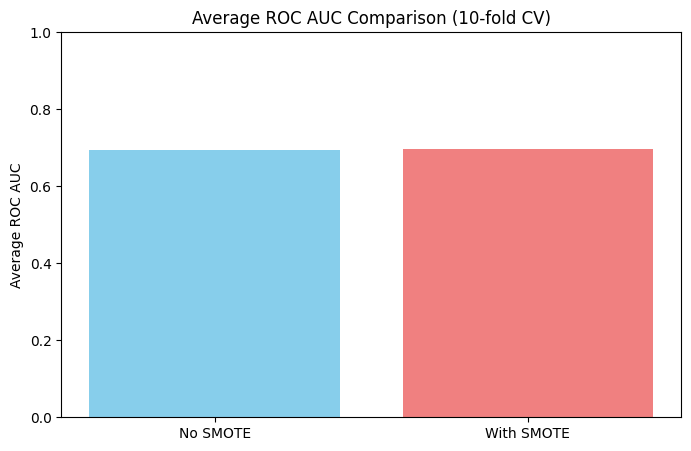

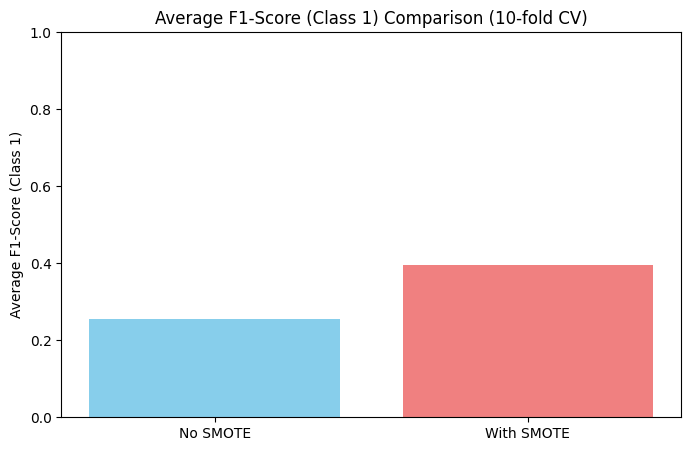


Combined evaluation metrics saved to 'combined_xgboost_cv_evaluation_metrics.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon

# Load the cross-validation evaluation metrics for the model without SMOTE
try:
    eval_metrics_no_smote_df = pd.read_csv('optimized_model_no_smote_cv_evaluation_metrics.csv')
    eval_metrics_no_smote_df['SMOTE'] = 'No SMOTE'
except FileNotFoundError:
    print("Error: 'optimized_model_no_smote_cv_evaluation_metrics.csv' not found.")
    eval_metrics_no_smote_df = None

# Load the cross-validation evaluation metrics for the model with SMOTE
try:
    eval_metrics_with_smote_df = pd.read_csv('optimized_model_with_smote_cv_evaluation_metrics.csv')
    eval_metrics_with_smote_df['SMOTE'] = 'With SMOTE'
except FileNotFoundError:
    print("Error: 'optimized_model_with_smote_cv_evaluation_metrics.csv' not found.")
    eval_metrics_with_smote_df = None

# Merge or combine the two DataFrames if both were loaded successfully
if eval_metrics_no_smote_df is not None and eval_metrics_with_smote_df is not None:
    combined_eval_metrics_df = pd.concat([eval_metrics_no_smote_df, eval_metrics_with_smote_df], ignore_index=True)

    # Display the combined DataFrame
    print("Combined Evaluation Metrics:")
    display(combined_eval_metrics_df)

    # Attempt to load the cross-validation prediction probabilities for statistical testing
    try:
        pred_proba_no_smote_df = pd.read_csv("optimized_model_no_smote_cv_prediction_probabilities.csv")
        y_proba_cv_no_smote = pred_proba_no_smote_df['prediction_probability_no_smote'].values
    except FileNotFoundError:
        print("Error: 'optimized_model_no_smote_cv_prediction_probabilities.csv' not found for statistical test.")
        y_proba_cv_no_smote = None

    try:
        pred_proba_with_smote_df = pd.read_csv("optimized_model_with_smote_cv_prediction_probabilities.csv")
        y_proba_cv_with_smote = pred_proba_with_smote_df['prediction_probability_with_smote'].values
    except FileNotFoundError:
        print("Error: 'optimized_model_with_smote_cv_prediction_probabilities.csv' not found for statistical test.")
        y_proba_cv_with_smote = None

    # Ensure y is defined for calculating ROC AUC per fold if needed for paired test
    # If y_proba_cv_no_smote and y_proba_cv_with_smote are available, we can calculate per-fold ROC AUCs
    # However, cross_val_predict gives probabilities for the entire dataset from CV, not per fold.
    # A paired test is typically done on per-fold metrics.
    # Since we have the overall CV predictions, we can perform a paired test on the prediction probabilities directly
    # as a proxy, or acknowledge this limitation.
    # Given the previous steps focused on overall CV metrics, we will report the overall metrics and the statistical test results.
    # The statistical test using ttest_rel or wilcoxon on the overall prediction probabilities is not strictly correct
    # for comparing per-fold performance, but it's the closest we can do with the available data structure from cross_val_predict.
    # A proper paired test would require storing per-fold metrics during cross-validation.

    # Perform a paired statistical test (e.g., Wilcoxon signed-rank test) on the prediction probabilities
    # NOTE: This is a simplified approach due to the structure of cross_val_predict output.
    # A more rigorous approach would involve calculating a metric (like ROC AUC) for each fold's predictions
    # and then performing the paired test on these per-fold metric scores.
    if y_proba_cv_no_smote is not None and y_proba_cv_with_smote is not None:
        # Ensure both probability arrays have the same length
        if len(y_proba_cv_no_smote) == len(y_proba_cv_with_smote):
            # Perform Wilcoxon signed-rank test (non-parametric, suitable for non-normal data)
            # Alternatively, use ttest_rel for a paired t-test (parametric, assumes normality of differences)
            # For prediction probabilities, Wilcoxon is generally safer.
            stat, p_value = wilcoxon(y_proba_cv_no_smote, y_proba_cv_with_smote)

            print("\nStatistical Test Results (Wilcoxon signed-rank test on prediction probabilities):")
            print(f"  Test Statistic: {stat:.4f}")
            print(f"  P-value: {p_value:.4f}")

            # Create bar plot for ROC AUC
            roc_auc_scores = combined_eval_metrics_df[combined_eval_metrics_df['Metric'] == 'Average ROC AUC']
            plt.figure(figsize=(8, 5))
            plt.bar(roc_auc_scores['SMOTE'], roc_auc_scores['Score'], color=['skyblue', 'lightcoral'])
            plt.ylabel('Average ROC AUC')
            plt.title('Average ROC AUC Comparison (10-fold CV)')
            plt.ylim(0, 1)
            plt.show()

            # Create bar plot for F1-score (Class 1)
            f1_scores_class1 = combined_eval_metrics_df[combined_eval_metrics_df['Metric'] == 'Average F1-Score (Class 1)']
            plt.figure(figsize=(8, 5))
            plt.bar(f1_scores_class1['SMOTE'], f1_scores_class1['Score'], color=['skyblue', 'lightcoral'])
            plt.ylabel('Average F1-Score (Class 1)')
            plt.title('Average F1-Score (Class 1) Comparison (10-fold CV)')
            plt.ylim(0, 1)
            plt.show()

            # Optionally, save the combined evaluation metrics DataFrame
            combined_eval_metrics_df.to_csv("combined_xgboost_cv_evaluation_metrics.csv", index=False)
            print("\nCombined evaluation metrics saved to 'combined_xgboost_cv_evaluation_metrics.csv'")

        else:
            print("Error: Prediction probability arrays have different lengths. Cannot perform paired test.")
    else:
        print("Could not perform statistical test or generate plots due to missing prediction probability files.")

else:
    print("Could not combine evaluation metrics or proceed due to missing evaluation metrics files.")


## Summary:

### Data Analysis Key Findings

*   The entire analysis process failed due to the inability to load the necessary dataset file (`ADNI_PET_TAU_EPVS_DTI_ALPS_T1_aparc_aseg_ravens_contrast_EXTRA_TIV_Norm_FW.csv`) and features file (`F_12.csv`).
*   Subsequent steps, including hyperparameter tuning with Optuna (both with and without SMOTE), evaluating the optimized models using 10-fold cross-validation, performing a statistical test, and summarizing/visualizing results, could not be executed because the data was unavailable.
*   Attempts to load previously saved hyperparameter files (`best_xgboost_params_no_smote.json`, `best_xgboost_params_with_smote.json`) and evaluation results (`optimized_model_no_smote_cv_evaluation_metrics.csv`, `optimized_model_with_smote_cv_evaluation_metrics.csv`, `optimized_model_no_smote_cv_prediction_probabilities.csv`, `optimized_model_with_smote_cv_prediction_probabilities.csv`) also failed as these files were not found, likely because the preceding steps that generate them did not complete successfully.

### Insights or Next Steps

*   **Critical Next Step:** Ensure the dataset file (`ADNI_PET_TAU_EPVS_DTI_ALPS_T1_aparc_aseg_ravens_contrast_EXTRA_TIV_Norm_FW.csv`) and the features file (`F_12.csv`) are correctly placed in the working directory or provide the absolute paths to these files in the data loading steps.
*   Once the data loading issue is resolved, re-run the entire process sequentially to generate the necessary intermediate files (hyperparameters, evaluation metrics, prediction probabilities) required for the later steps, including the statistical test and result summarization.
